In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *

import seaborn as sns
import matplotlib.pyplot as plt
plt.rc("font", size=14)
plt.style.use("ggplot")
sns.set(style="darkgrid")

pd.set_option("display.max_columns", 120)
pd.set_option("display.max_rows", 120)

In [3]:
base= pd.read_csv('nfl_game_data_for_simulation.csv')
print(f'Rows : {base.shape[0]}')
print(f'Columns : {base.shape[1]}')
base.head(20)

Rows : 6161
Columns : 20


,id,home_team_id,away_team_id,home_abbrev,away_abbrev,date,week,season,home_score,away_score,temp,humd,wind,cond,spread,ou,home_moneyline,away_moneyline,playoffs,neutral
0,1,19,4,NE,BUF,9/14/09,1,2009,25,24,70,53,5,Clear,-10.5,47.0,0,0,0,0
1,2,22,19,NYJ,NE,9/20/09,2,2009,16,9,69,41,5,Clear,3.5,46.0,0,0,0,0
2,3,19,2,NE,ATL,9/27/09,3,2009,26,10,62,96,0,Rain,-4.5,47.0,0,0,0,0
3,4,19,3,NE,BAL,10/4/09,4,2009,27,21,64,80,2,Cloudy,-1.0,44.0,0,0,0,0
4,5,10,19,DEN,NE,10/11/09,5,2009,20,17,30,72,4,Cloudy,3.0,41.0,0,0,0,0
5,6,19,31,NE,TEN,10/18/09,6,2009,59,0,39,94,19,Snow,-9.0,43.0,0,0,0,0
6,7,30,19,TB,NE,10/25/09,7,2009,7,35,59,59,16,Partly Cloudy,14.5,45.0,0,0,0,1
7,8,19,17,NE,MIA,11/8/09,9,2009,27,17,65,44,8,Sunny,-10.5,46.5,0,0,0,0
8,9,14,19,IND,NE,11/15/09,10,2009,35,34,0,0,0,Closed Roof,-3.0,49.5,0,0,0,0
9,10,19,22,NE,NYJ,11/22/09,11,2009,31,14,45,68,10,Cloudy,-10.5,45.0,0,0,0,0


In [4]:
df_home = base.copy().assign(
        team_id             = lambda x: x['home_team_id'],
        team_abbrev         = lambda x: x['home_abbrev'],
        team_score          = lambda x: x['home_score'],
        team_moneyline      = lambda x: x['home_moneyline'],
        team_spread         = lambda x: x['spread'],
        opponent_id         = lambda x: x['away_team_id'],
        opponent_abbrev     = lambda x: x['away_abbrev'],
        opponent_score      = lambda x: x['away_score'],
        opponent_moneyline  = lambda x: x['away_moneyline'],
        opponent_spread     = lambda x: -x['spread'],
        is_home             = 1
    )

df_away = base.copy().assign(
        team_id             = lambda x: x['away_team_id'],
        team_abbrev         = lambda x: x['away_abbrev'],
        team_score          = lambda x: x['away_score'],    
        team_moneyline      = lambda x: x['away_moneyline'],
        team_spread         = lambda x: -x['spread'],
        opponent_id         = lambda x: x['home_team_id'],
        opponent_abbrev     = lambda x: x['home_abbrev'],
        opponent_score      = lambda x: x['home_score'],
        opponent_moneyline  = lambda x: x['home_moneyline'],
        opponent_spread     = lambda x: x['spread'],
        is_home             = 0
    )
# Concatenate df_home and df_away using pd.concat
combo = pd.concat([df_home, df_away], ignore_index=True)

del df_home, df_away #free up memory

In [5]:
combo['team_implied_total'] = (combo['ou'] / 2) - (combo['team_spread'] / 2)
combo['opponent_implied_total'] = (combo['ou'] / 2) - (combo['opponent_spread'] / 2)

In [6]:
max_score_df = combo.groupby(['week','season'])['team_score'].agg('max')
max_score_df = max_score_df.reset_index()
max_score_df.columns = ['week','season','highest_score_of_week']
max_score_df.head()

,week,season,highest_score_of_week
0,1,2000,41
1,1,2001,45
2,1,2002,49
3,1,2003,49
4,1,2004,35


In [7]:
combo = combo.merge(max_score_df, on=['week', 'season'], how='left')

In [8]:
combo['is_highest_score_of_week'] = np.where(combo['highest_score_of_week'] == combo['team_score'], 1, 0)

In [9]:
value_counts = combo.groupby(['week','season'])['is_highest_score_of_week'].value_counts().reset_index(name="count")
value_counts[(value_counts['is_highest_score_of_week'] == 1) & (value_counts['count'] > 1)].head()

,week,season,is_highest_score_of_week,count
1,1,2000,1,2
21,1,2010,1,2
37,1,2018,1,2
55,2,2004,1,2
113,3,2010,1,2


<Axes: xlabel='team_score', ylabel='Count'>

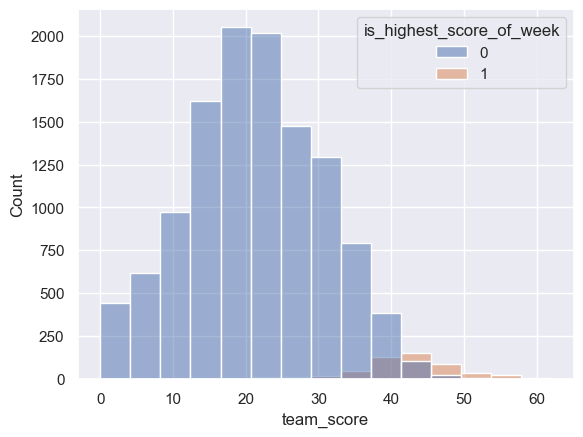

In [10]:
sns.histplot(data=combo, x="team_score", hue='is_highest_score_of_week', bins=15)

<Axes: xlabel='team_implied_total', ylabel='Count'>

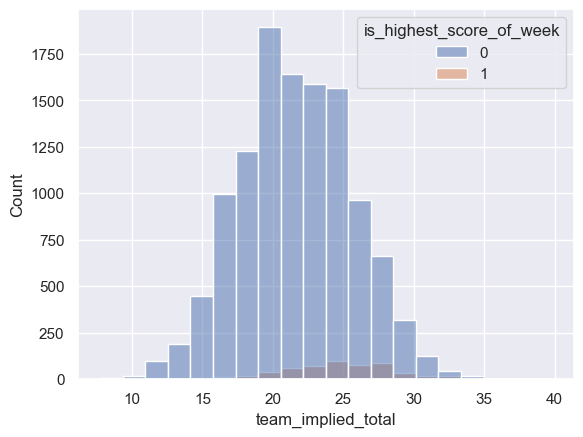

In [11]:
sns.histplot(data=combo, x="team_implied_total", hue='is_highest_score_of_week', bins=20)

<Axes: xlabel='team_implied_total', ylabel='team_score'>

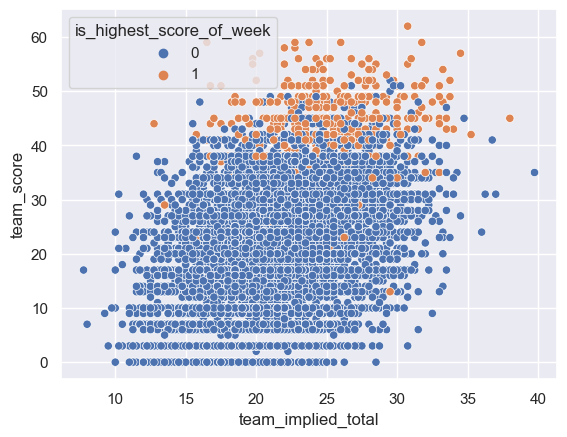

In [12]:
sns.scatterplot(data=combo, x="team_implied_total", y="team_score", hue="is_highest_score_of_week")

In [13]:
combo = combo[combo['season'] >= 2012]
#invalid ML prior

In [14]:
combo

,id,home_team_id,away_team_id,home_abbrev,away_abbrev,date,week,season,home_score,away_score,temp,humd,wind,cond,spread,ou,home_moneyline,away_moneyline,playoffs,neutral,team_id,team_abbrev,team_score,team_moneyline,team_spread,opponent_id,opponent_abbrev,opponent_score,opponent_moneyline,opponent_spread,is_home,team_implied_total,opponent_implied_total,highest_score_of_week,is_highest_score_of_week
3188,5321,21,9,NYG,DAL,9/5/12,1,2012,17,24,77,63,5,Fair,-4.0,47.0,-220,180,0,0,21,NYG,17,-220,-4.0,9,DAL,24,180,4.0,1,25.5,21.5,48,0
3189,5322,20,32,NO,WSH,9/9/12,1,2012,32,40,0,0,0,Dome,-7.5,50.5,-400,310,0,0,20,NO,32,-400,-7.5,32,WSH,40,310,7.5,1,29.0,21.5,48,0
3190,5323,11,29,DET,STL,9/9/12,1,2012,27,23,0,0,0,Dome,-7.5,45.5,-400,310,0,0,11,DET,27,-400,-7.5,29,STL,23,310,7.5,1,26.5,19.0,48,0
3191,5324,1,28,ARI,SEA,9/9/12,1,2012,20,16,0,0,0,Closed Roof,3.0,41.0,125,-145,0,0,1,ARI,20,125,3.0,28,SEA,16,-145,-3.0,1,19.0,22.0,48,0
3192,5325,12,27,GB,SF,9/9/12,1,2012,22,30,72,40,11,Partly Cloudy,-5.0,47.0,-250,200,0,0,12,GB,22,-250,-5.0,27,SF,30,200,5.0,1,26.0,21.0,48,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12317,8292,24,21,PHI,NYG,1/21/23,20,2022,38,7,40,55,6,Overcast,-7.5,48.5,-390,310,1,0,21,NYG,7,310,7.5,24,PHI,38,-390,-7.5,0,20.5,28.0,38,0
12318,8293,4,7,BUF,CIN,1/22/23,20,2022,10,27,32,100,4,Light Snow,-5.5,48.5,-255,205,1,0,7,CIN,27,205,5.5,4,BUF,10,-255,-5.5,0,21.5,27.0,38,0
12319,8294,27,9,SF,DAL,1/22/23,20,2022,19,12,55,47,19,Sunny,-3.5,46.5,-176,148,1,0,9,DAL,12,148,3.5,27,SF,19,-176,-3.5,0,21.5,25.0,38,0
12320,8295,16,7,KC,CIN,1/29/23,21,2022,23,20,22,55,13,Partly Cloudy,-1.5,48.5,-136,116,1,0,7,CIN,20,116,1.5,16,KC,23,-136,-1.5,0,23.5,25.0,31,0


In [15]:
combo['home_beat_spread'] = (combo['home_score'] + combo['spread']) > combo['away_score']
combo['away_beat_spread'] = (combo['away_score'] - combo['spread']) > combo['home_score']

In [16]:
# def calculate_ats_record(team_id, season, df):
#     # Filter for games involving the team in the given season
#     team_games = df[(df['season'] == season) & ((df['home_team_id'] == team_id) | (df['away_team_id'] == team_id))]
    
#     # Count the number of times the team beat the spread
#     ats_wins = (
#         ((team_games['home_team_id'] == team_id) & team_games['home_beat_spread']) | 
#         ((team_games['away_team_id'] == team_id) & team_games['away_beat_spread'])
#     ).sum()

#     # Total number of games played by the team in the season
#     total_games = team_games.shape[0]

#     return ats_wins, total_games

In [17]:
# Converting date to datetime for proper sorting
combo['date'] = pd.to_datetime(combo['date'])

In [18]:
combo

,id,home_team_id,away_team_id,home_abbrev,away_abbrev,date,week,season,home_score,away_score,temp,humd,wind,cond,spread,ou,home_moneyline,away_moneyline,playoffs,neutral,team_id,team_abbrev,team_score,team_moneyline,team_spread,opponent_id,opponent_abbrev,opponent_score,opponent_moneyline,opponent_spread,is_home,team_implied_total,opponent_implied_total,highest_score_of_week,is_highest_score_of_week,home_beat_spread,away_beat_spread
3188,5321,21,9,NYG,DAL,2012-09-05,1,2012,17,24,77,63,5,Fair,-4.0,47.0,-220,180,0,0,21,NYG,17,-220,-4.0,9,DAL,24,180,4.0,1,25.5,21.5,48,0,False,True
3189,5322,20,32,NO,WSH,2012-09-09,1,2012,32,40,0,0,0,Dome,-7.5,50.5,-400,310,0,0,20,NO,32,-400,-7.5,32,WSH,40,310,7.5,1,29.0,21.5,48,0,False,True
3190,5323,11,29,DET,STL,2012-09-09,1,2012,27,23,0,0,0,Dome,-7.5,45.5,-400,310,0,0,11,DET,27,-400,-7.5,29,STL,23,310,7.5,1,26.5,19.0,48,0,False,True
3191,5324,1,28,ARI,SEA,2012-09-09,1,2012,20,16,0,0,0,Closed Roof,3.0,41.0,125,-145,0,0,1,ARI,20,125,3.0,28,SEA,16,-145,-3.0,1,19.0,22.0,48,0,True,False
3192,5325,12,27,GB,SF,2012-09-09,1,2012,22,30,72,40,11,Partly Cloudy,-5.0,47.0,-250,200,0,0,12,GB,22,-250,-5.0,27,SF,30,200,5.0,1,26.0,21.0,48,0,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12317,8292,24,21,PHI,NYG,2023-01-21,20,2022,38,7,40,55,6,Overcast,-7.5,48.5,-390,310,1,0,21,NYG,7,310,7.5,24,PHI,38,-390,-7.5,0,20.5,28.0,38,0,True,False
12318,8293,4,7,BUF,CIN,2023-01-22,20,2022,10,27,32,100,4,Light Snow,-5.5,48.5,-255,205,1,0,7,CIN,27,205,5.5,4,BUF,10,-255,-5.5,0,21.5,27.0,38,0,False,True
12319,8294,27,9,SF,DAL,2023-01-22,20,2022,19,12,55,47,19,Sunny,-3.5,46.5,-176,148,1,0,9,DAL,12,148,3.5,27,SF,19,-176,-3.5,0,21.5,25.0,38,0,True,False
12320,8295,16,7,KC,CIN,2023-01-29,21,2022,23,20,22,55,13,Partly Cloudy,-1.5,48.5,-136,116,1,0,7,CIN,20,116,1.5,16,KC,23,-136,-1.5,0,23.5,25.0,31,0,True,False


In [19]:
year_for_test_and_train_split = 2021
df_train = combo[combo['season'] < year_for_test_and_train_split]
df_test = combo[combo['season'] >= year_for_test_and_train_split]

In [20]:
info = df_train[['team_implied_total','team_score']].describe()
print(info)
league_scoring_standard_deviation = info[info.index == 'std']['team_score']

       team_implied_total   team_score
count         4810.000000  4810.000000
mean            22.834615    23.028690
std              3.774588    10.133052
min              9.500000     0.000000
25%             20.250000    16.000000
50%             22.750000    23.000000
75%             25.500000    30.000000
max             39.750000    59.000000


In [21]:
def simulateHighestScoringTeamOfWeek(df, number_of_simulations = 10000):
  df['count_simulated_is_highest_score_of_week'] = 0

  for sim in range(0, number_of_simulations):
    
    # random normal distribution with league average standard deviation, centered at team implied total
    df['simulated_team_score'] = np.random.normal(df['team_implied_total'], league_scoring_standard_deviation).round(0)
    
    # figure out the highest simulated score of each week and merge it back on to the dataframe
    max_score_df = df.groupby(['week','season'])['simulated_team_score'].agg('max')
    max_score_df = max_score_df.reset_index()
    max_score_df.columns = ['week','season','simulated_highest_score_of_week']
    df = df.merge(max_score_df, on=['week', 'season'], how='left')
    
    # identify if each team had the highest simulated score of the week
    df['simulated_is_highest_score_of_week'] = np.where(df['simulated_highest_score_of_week'] == df['simulated_team_score'], 1, 0)

    # look for ties and add a column with the total teams who had the highest score of the week
    df['total_teams_with_highest_score_of_week'] = df.groupby(['week','season'])['simulated_is_highest_score_of_week'].transform("sum")

    # iterate a counter that says if a team had the highest simulated score of the week (add 1 / number of teams with the highest score to account for dead heat rules)    
    df['count_simulated_is_highest_score_of_week'] = np.where(df['simulated_is_highest_score_of_week'] == 1, df['count_simulated_is_highest_score_of_week'] + (1 / df['total_teams_with_highest_score_of_week']), df['count_simulated_is_highest_score_of_week'])
    
    # drop column that we merged on to avoid duplicate name clashes
    df = df.drop(columns=['simulated_highest_score_of_week'])

  # calculate the probability by dividing the iterative count by the number of simulations
  df['simulated_highest_score_of_week_probability'] = df['count_simulated_is_highest_score_of_week'] / number_of_simulations

  # if we just pass in one week of data, let's print out some values for testing
  if len(df['week'].unique()) == 1:
    print(df[['week','season','team_abbrev','team_implied_total','team_score','count_simulated_is_highest_score_of_week','simulated_highest_score_of_week_probability']])
    print("Total Probability: " + str(df['simulated_highest_score_of_week_probability'].sum()))

  return df

In [22]:
test_simulation_results = simulateHighestScoringTeamOfWeek(df_test,100000)

In [23]:
test_simulation_results

,id,home_team_id,away_team_id,home_abbrev,away_abbrev,date,week,season,home_score,away_score,temp,humd,wind,cond,spread,ou,home_moneyline,away_moneyline,playoffs,neutral,team_id,team_abbrev,team_score,team_moneyline,team_spread,opponent_id,opponent_abbrev,opponent_score,opponent_moneyline,opponent_spread,is_home,team_implied_total,opponent_implied_total,highest_score_of_week,is_highest_score_of_week,home_beat_spread,away_beat_spread,count_simulated_is_highest_score_of_week,simulated_team_score,simulated_is_highest_score_of_week,total_teams_with_highest_score_of_week,simulated_highest_score_of_week_probability
0,7728,30,9,TB,DAL,2021-09-09,1,2021,31,29,82,85,9,Partly Cloudy,-9.5,52.5,-430,340,0,0,30,TB,31,-430,-9.5,9,DAL,29,340,9.5,1,31.00,21.50,41,0,False,True,9993.033333,23.0,0,1,0.099930
1,7729,31,1,TEN,ARI,2021-09-12,1,2021,13,38,82,55,8,Sunny,-2.5,53.5,-138,118,0,0,31,TEN,13,-138,-2.5,1,ARI,38,118,2.5,1,28.00,25.50,41,0,False,True,5829.976190,12.0,0,1,0.058300
2,7730,16,8,KC,CLE,2021-09-12,1,2021,33,29,88,43,8,Sunny,-5.5,54.5,-230,190,0,0,16,KC,33,-230,-5.5,8,CLE,29,190,5.5,1,30.00,24.50,41,0,False,True,8357.233333,35.0,0,1,0.083572
3,7731,13,15,HOU,JAC,2021-09-12,1,2021,37,21,84,58,4,Partly Cloudy,3.5,45.5,148,-176,0,0,13,HOU,37,148,3.5,15,JAC,21,-176,-3.5,1,21.00,24.50,41,0,True,False,1326.650000,23.0,0,1,0.013267
4,7732,7,18,CIN,MIN,2021-09-12,1,2021,27,24,81,54,15,Sunny,3.0,47.5,124,-146,0,0,7,CIN,27,124,3.0,18,MIN,24,-146,-3.0,1,22.25,25.25,41,0,True,False,1787.733333,11.0,0,1,0.017877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1131,8292,24,21,PHI,NYG,2023-01-21,20,2022,38,7,40,55,6,Overcast,-7.5,48.5,-390,310,1,0,21,NYG,7,310,7.5,24,PHI,38,-390,-7.5,0,20.50,28.00,38,0,True,False,5749.500000,17.0,0,1,0.057495
1132,8293,4,7,BUF,CIN,2023-01-22,20,2022,10,27,32,100,4,Light Snow,-5.5,48.5,-255,205,1,0,7,CIN,27,205,5.5,4,BUF,10,-255,-5.5,0,21.50,27.00,38,0,False,True,6647.666667,34.0,0,1,0.066477
1133,8294,27,9,SF,DAL,2023-01-22,20,2022,19,12,55,47,19,Sunny,-3.5,46.5,-176,148,1,0,9,DAL,12,148,3.5,27,SF,19,-176,-3.5,0,21.50,25.00,38,0,True,False,6635.000000,17.0,0,1,0.066350
1134,8295,16,7,KC,CIN,2023-01-29,21,2022,23,20,22,55,13,Partly Cloudy,-1.5,48.5,-136,116,1,0,7,CIN,20,116,1.5,16,KC,23,-136,-1.5,0,23.50,25.00,31,0,True,False,24746.500000,26.0,1,1,0.247465


In [24]:
def printRocCurve(y_test, predicted_probabilities, auc):
    fpr, tpr, thresholds = roc_curve(y_test, predicted_probabilities)
    plt.figure()
    plt.plot(fpr, tpr, label=' (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

AUC: 0.746751851200594
Logloss: 0.1555210610018774
Brier: 0.03791198583884385


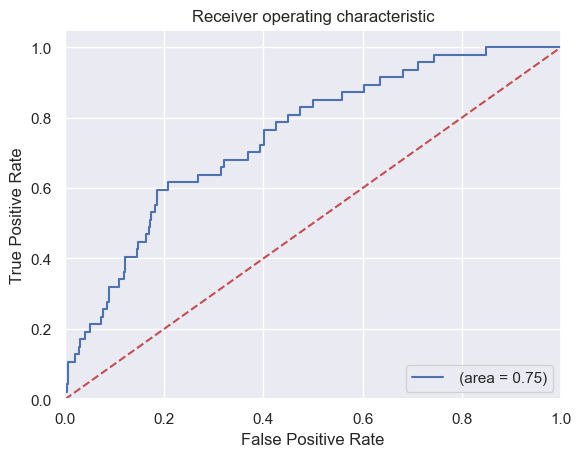

In [25]:
auc = roc_auc_score(test_simulation_results['is_highest_score_of_week'], test_simulation_results['simulated_highest_score_of_week_probability'])
logloss = log_loss(test_simulation_results['is_highest_score_of_week'], test_simulation_results['simulated_highest_score_of_week_probability'])
brier = brier_score_loss(test_simulation_results['is_highest_score_of_week'], test_simulation_results['simulated_highest_score_of_week_probability'])

print("AUC: " + str(auc))
print("Logloss: " + str(logloss))
print("Brier: " + str(brier))

printRocCurve(test_simulation_results['is_highest_score_of_week'], test_simulation_results['simulated_highest_score_of_week_probability'], auc)

In [26]:
divisional_projections = test_simulation_results[(test_simulation_results['week'] == 20) & (test_simulation_results['season'] == 2022)]

divisional_projections = divisional_projections[['team_abbrev','team_implied_total','simulated_highest_score_of_week_probability']]

divisional_projections = divisional_projections.rename(columns={"team_abbrev": "Team", "team_implied_total": "Implied Team Total", "simulated_highest_score_of_week_probability": "Probability"})

divisional_projections['Price'] = 1000*round(round((100-100*divisional_projections['Probability'])/divisional_projections['Probability'],0)/1000,2)

divisional_projections['Price'] = "+" + divisional_projections['Price'].map('{:.0f}'.format).astype(str)

total_probability = divisional_projections['Probability'].sum()

divisional_projections = divisional_projections.sort_values(by=['Probability'], ascending=False)

divisional_projections['Probability'] = divisional_projections['Probability'].map('{:,.2%}'.format)

print(divisional_projections)

print('Total Probability: {:,.2%}'.format(total_probability))

     Team  Implied Team Total Probability  Price
562    KC                30.5      27.43%   +260
563   PHI                28.0      18.77%   +430
564   BUF                27.0      16.49%   +510
565    SF                25.0      12.18%   +720
1132  CIN                21.5       6.65%  +1400
1133  DAL                21.5       6.63%  +1410
1130  JAC                21.0       6.10%  +1540
1131  NYG                20.5       5.75%  +1640
Total Probability: 100.00%
